# Digits OCR

 Base code comes from [Keras CRNN Tutorial](https://keras.io/examples/vision/captcha_ocr/)
 
 * Version 12 - CRNN (Deeper Network - 7 conv layers)
 * Version 10 - CRNN with STN block
 * Version 6 - CRNN (Shallower Network - 2 conv layers)

## Utility Functions

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style("darkgrid")

In [3]:
def plot_grid(dataset, h=5, w=5, title=""):
    f, ax = plt.subplots(h, w, figsize=(18, 18))
    for batch in dataset.shuffle(100).take(1):
        images = batch["image"]
        labels = batch["label"]
        for i in range(h*w):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // h, i % w].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // h, i % w].axis("off")
            ax[i // h, i % w].set_title(label, fontdict={"fontsize": 20})
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

In [4]:
def plot_hist(hist):
    plt.figure(figsize=(6, 6))
    plt.plot(hist.history["loss"])
    plt.plot(hist.history["val_loss"])
    plt.title("Loss Plot")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()

## Digits OCR

In [5]:
from collections import Counter
from itertools import chain
import os
from pathlib import Path
import random
import requests

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Activation, BatchNormalization, Bidirectional, Conv2D, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.models import Model

In [6]:
def seed_everything(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)

In [7]:
df = pd.read_csv("../input/arya-date/updated_train_data.csv")

In [8]:
df.head()

,tag,label
0,train/0.png,57862871
1,train/1.png,96302881
2,train/2.png,95646781
3,train/3.png,86355781
4,train/4.png,49203781


In [9]:
# Path to the data directory
data_dir = Path("../input/arya-date/train/train/")

# Get list of all the images
images = df["tag"].apply(lambda x: f"../input/arya-date/train/{x}")
labels = df["label"].astype(str).str.zfill(8)
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 32

# Desired image dimensions
img_width = 250
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  13237
Number of labels found:  13237
Number of unique characters:  10
Characters present:  {'3', '0', '2', '6', '1', '9', '5', '7', '4', '8'}


## Preprocessing

In [10]:
# Mapping characters to integers
char_to_num = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=list(characters), num_oov_indices=0, mask_token=None
)

# Mapping integers back to original characters
num_to_char = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

In [11]:
def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid

In [12]:
# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

In [13]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

## Create `Dataset` objects

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

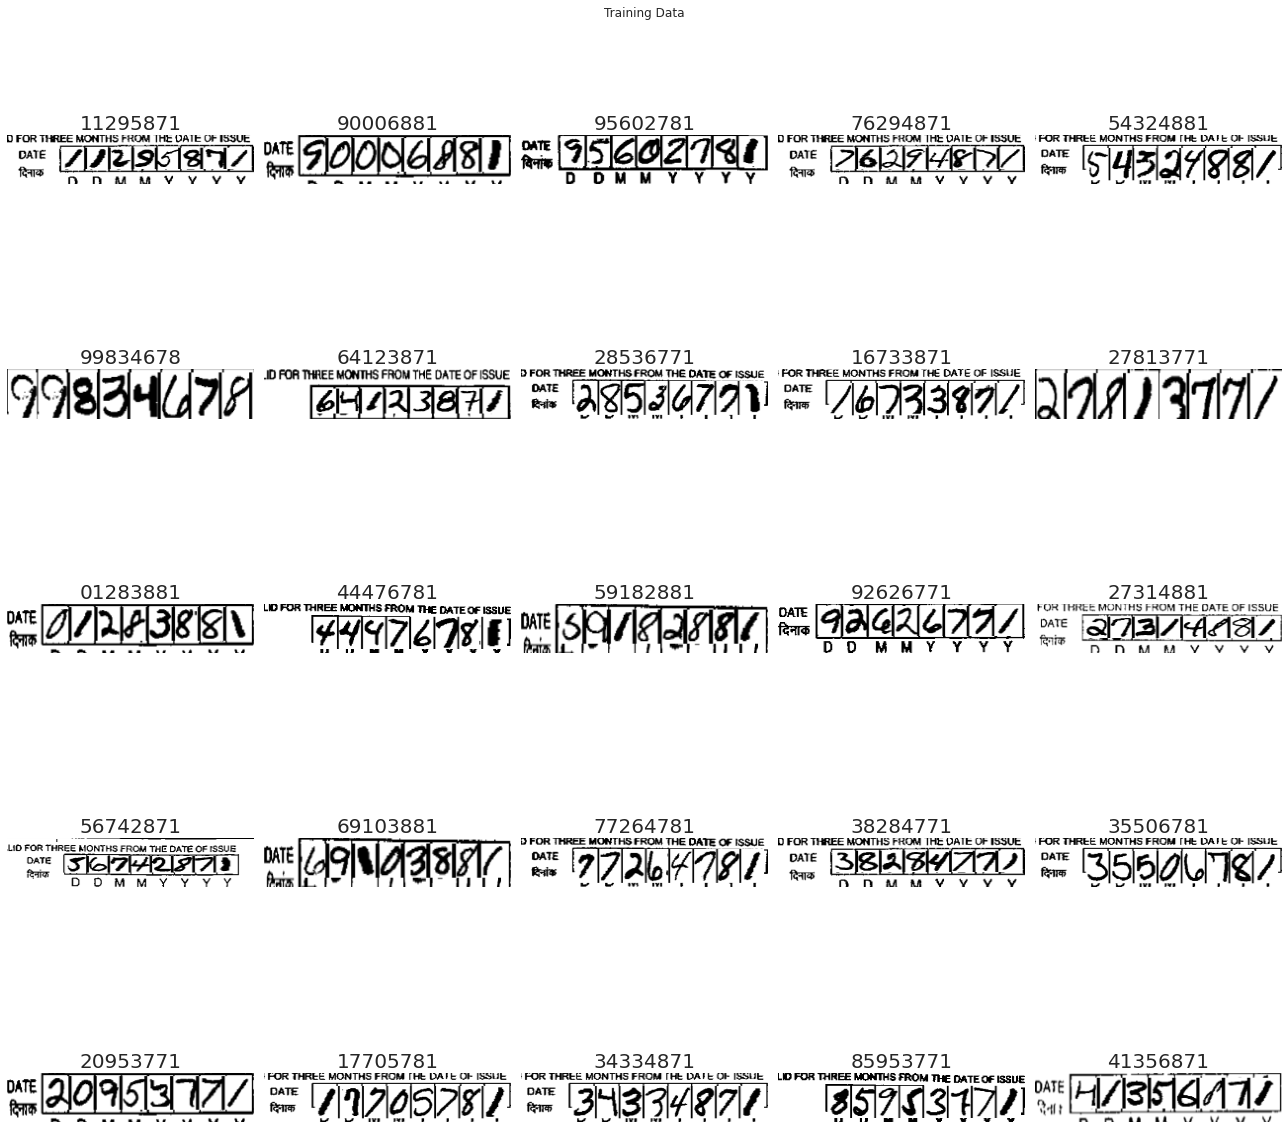

In [15]:
plot_grid(train_dataset, title="Training Data")

In [16]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

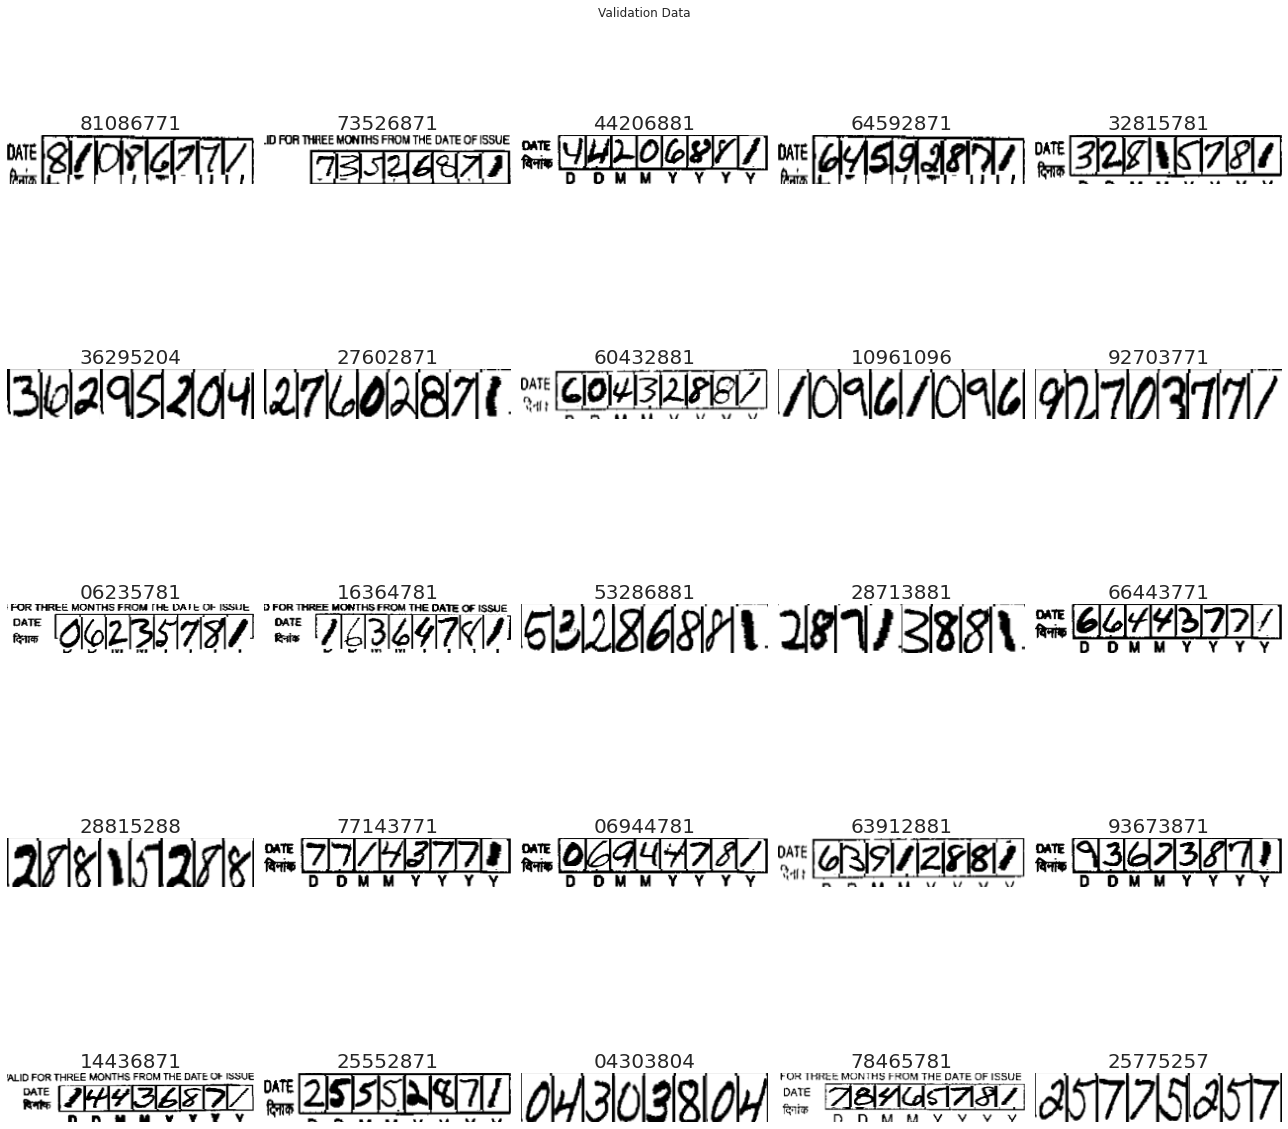

In [17]:
plot_grid(validation_dataset, title="Validation Data")

## Model

In [18]:
class CTCLayer(Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred

In [19]:
def build_crnn_model():
    # Inputs to the model
    input_img = Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = Input(name="label", shape=(None,), dtype="float32")

    """
    Why is the need for 7 conv layers?
    """
    # First conv block
    x = Conv2D(32, (3, 3), activation="relu", padding="same", name="conv_1")(input_img)
    x = Conv2D(64, (3, 3), activation="relu", padding="same", name="conv_2")(x)
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_3")(x)
    x = BatchNormalization(name="bn_1")(x)
    x = MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = Conv2D(128, (3, 3), activation="relu", padding="same", name="conv_4")(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="conv_5")(x)
    x = BatchNormalization(name="bn_2")(x)
    x = MaxPooling2D((2, 2), name="pool2")(x)

    # Third conv block
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="conv_6")(x)
    x = Conv2D(256, (3, 3), activation="relu", padding="same", name="conv_7")(x)
    x = BatchNormalization(name="bn_3")(x)
    
    # We have used two max pool with pool size and strides of 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing it to RNNs
    new_shape = ((img_width // 4), (img_height // 4) * 256)
    x = Reshape(target_shape=new_shape, name="reshape")(x)
    x = Dense(128, activation="relu", name="dense1")(x)
    x = Dropout(0.2)(x)

    # RNNs
    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.2))(x)
    x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = Dense(len(characters) + 1, activation="softmax", name="dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model

## Training

In [20]:
# Get the model
model = build_crnn_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 250, 50, 1)] 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 250, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
conv_2 (Conv2D)                 (None, 250, 50, 64)  18496       conv_1[0][0]                     
__________________________________________________________________________________________________
conv_3 (Conv2D)                 (None, 250, 50, 128) 73856       conv_2[0][0]                     
_______________________________________________________________________________________

In [21]:
epochs = 80
early_stopping_patience = 10
# Add early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/80
373/373 [==============================] - 76s 203ms/step - loss: 9.6362 - val_loss: 11.7804
Epoch 2/80
373/373 [==============================] - 42s 113ms/step - loss: 0.7104 - val_loss: 0.8216
Epoch 3/80
373/373 [==============================] - 43s 115ms/step - loss: 0.4256 - val_loss: 1.0886
Epoch 4/80
373/373 [==============================] - 43s 116ms/step - loss: 0.2889 - val_loss: 0.8698
Epoch 5/80
373/373 [==============================] - 43s 115ms/step - loss: 0.2442 - val_loss: 0.7904
Epoch 6/80
373/373 [==============================] - 43s 116ms/step - loss: 0.2019 - val_loss: 0.5617
Epoch 7/80
373/373 [==============================] - 45s 120ms/step - loss: 0.1924 - val_loss: 0.3364
Epoch 8/80
373/373 [==============================] - 44s 117ms/step - loss: 0.1595 - val_loss: 1.2813
Epoch 9/80
373/373 [==============================] - 43s 114ms/step - loss: 0.1618 - val_loss: 0.7166
Epoch 10/80
373/373 [==============================] - 45s 120ms/step - 

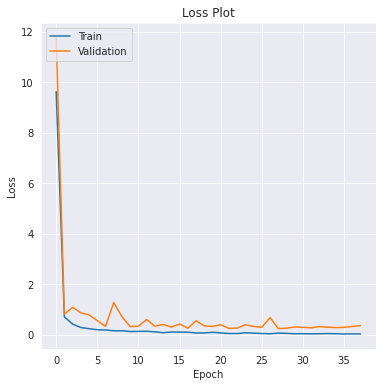

In [22]:
plot_hist(history)

**Model definitely overfits. The shallower version with a similar architecture however, doesn't overfit & exhibits a proper train/validation loss. Refer to *Version 6* of this notebook for refernce**

In [23]:
model.save("crnn_model.h5")

## Inference

In [24]:
# Get the prediction model by extracting layers till the output layer
prediction_model = tf.keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 250, 50, 1)]      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 250, 50, 32)       320       
_________________________________________________________________
conv_2 (Conv2D)              (None, 250, 50, 64)       18496     
_________________________________________________________________
conv_3 (Conv2D)              (None, 250, 50, 128)      73856     
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 250, 50, 128)      512       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 125, 25, 128)      0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 125, 25, 128)     

In [25]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [26]:
def get_all_preds(dataset):
    """
    Utility function that returns both model prediction & actual labels
    """
    decoded_text, actuals_text = [], []
    for batch in dataset:
        batch_images = batch["image"]
        batch_labels = batch["label"]

        preds = prediction_model.predict(batch_images)
        pred_texts = decode_batch_predictions(preds)

        orig_texts = []
        for label in batch_labels:
            label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
            orig_texts.append(label)

        decoded_text.append(pred_texts)
        actuals_text.append(orig_texts)

    # flatten 2D list
    decoded_text = list(chain.from_iterable(decoded_text))
    actuals_text = list(chain.from_iterable(actuals_text))
    return decoded_text, actuals_text

### Validation Data Evaluation

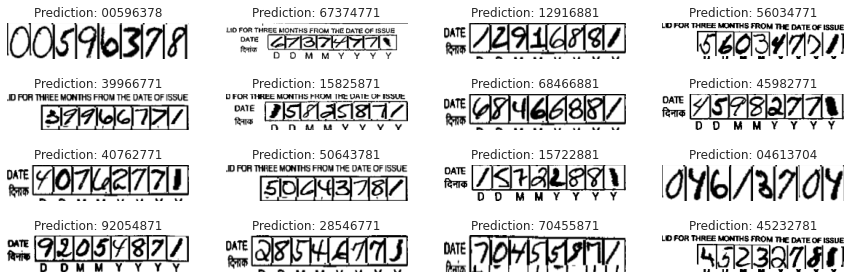

In [27]:
#  Let's check results on some validation samples
for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [28]:
decoded_text, actuals_text = get_all_preds(validation_dataset)

In [29]:
print(f"Validation Data Accuracy: {accuracy_score(actuals_text, decoded_text):.5f}")

Validation Data Accuracy: 0.95166


**PostProcessing** 
* Predicted label length=9 - Remove the last 1

In [30]:
def remove_last_one(label):
    idx = label.rfind("1")
    return label[:idx] + label[idx+1:]

In [31]:
decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]

In [32]:
print(f"Validation Data Accuracy (Post Processing): {accuracy_score(actuals_text, decoded_text):.5f}")

Validation Data Accuracy (Post Processing): 0.95166


### Training Data Evaluation

In [33]:
decoded_text, actuals_text = get_all_preds(train_dataset)

In [34]:
print(f"Training Data Accuracy: {accuracy_score(actuals_text, decoded_text):.5f}")

Training Data Accuracy: 0.98355


In [35]:
decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]
print(f"Training Data Accuracy (Post Processing): {accuracy_score(actuals_text, decoded_text):.5f}")

Training Data Accuracy (Post Processing): 0.98355


## Test Data Prediction

In [36]:
x_test = [f"../input/arya-date/test/test/{x}.png" for x in range(1000)]
y_test = ["11111111"]*len(x_test)

In [37]:
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (
    test_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.experimental.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
)

In [38]:
decoded_text, _ = get_all_preds(test_dataset)

In [39]:
decoded_text = [remove_last_one(x) if len(x)==9 else x for x in decoded_text]

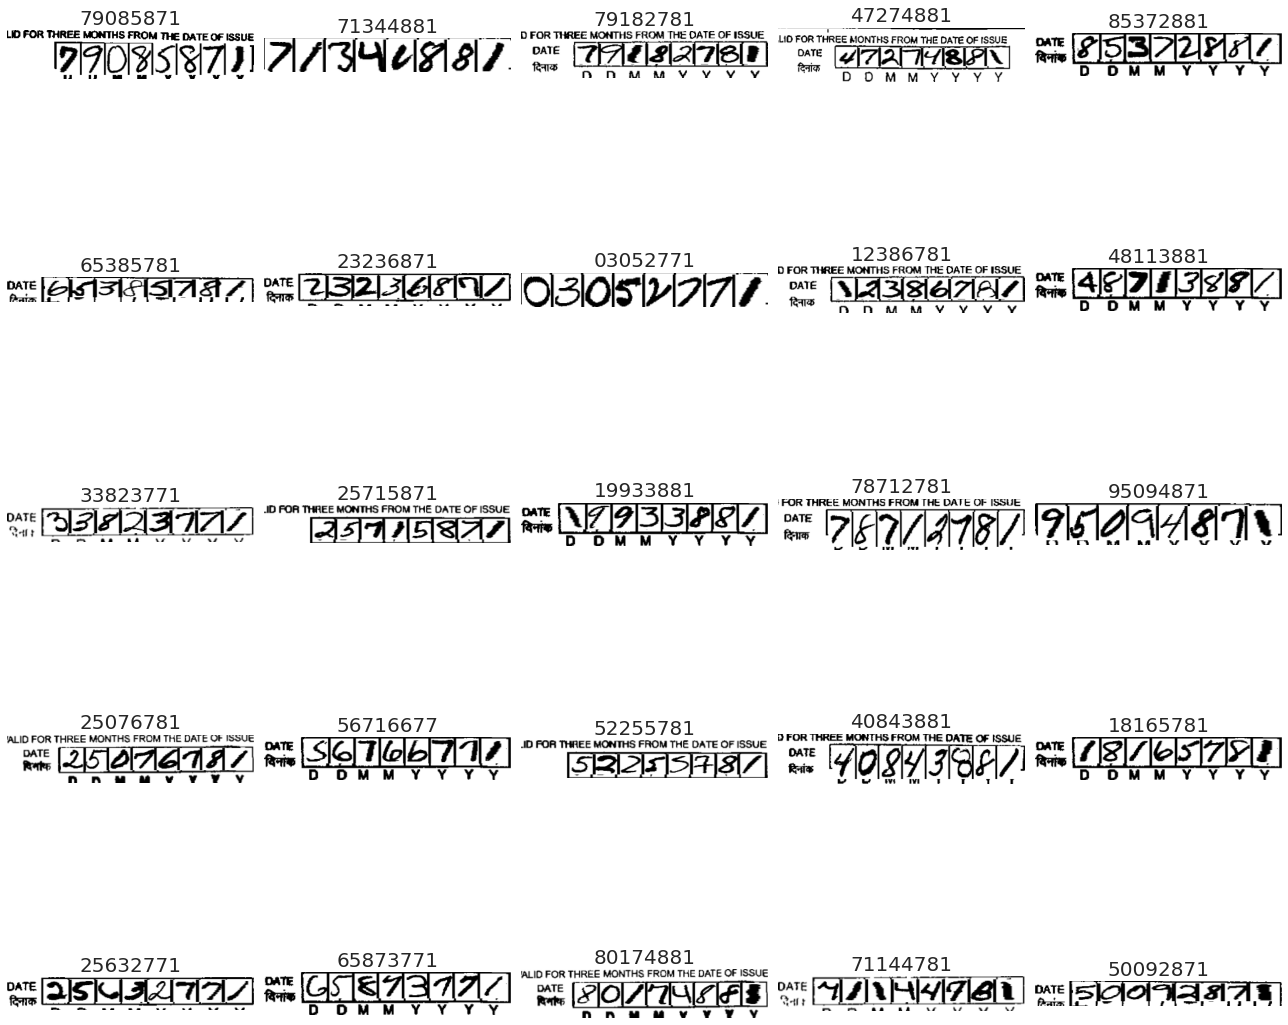

In [40]:
h, w = 5, 5
f, ax = plt.subplots(h, w, figsize=(18, 18))
random_indexes = random.sample(range(len(images)), k=h*w)
for i, j in enumerate(random_indexes):
    ax[i // h, i % w].imshow(cv2.imread(x_test[i]))
    ax[i // h, i % w].axis("off")
    ax[i // h, i % w].set_title(decoded_text[i], fontdict={"fontsize": 20})
plt.tight_layout()
plt.show()

## Submission

In [41]:
submission = pd.DataFrame()
submission["tag"] = range(1000)
submission["label"] = decoded_text
submission.to_csv("submission.csv", index=False)

In [42]:
submission.shape

(1000, 2)

In [43]:
submission.head()

,tag,label
0,0,79085871
1,1,71344881
2,2,79182781
3,3,47274881
4,4,85372881


In [44]:
submission["label"].astype(str).str.len().value_counts()

8     999
12      1
Name: label, dtype: int64

In [45]:
PUBLIC_host = "http://13.232.114.193"
SUBMISSION_URL = PUBLIC_host + ":8080/submit"
LEADERBOARD_URL = PUBLIC_host + ":8080/leaderboard"
DATA_URL = PUBLIC_host + ":9600"
TAG = "deeper_crnn_v1"

In [46]:
sub_json = submission.to_json()
data = {
    "username": "aditya",
    "password": "sdhjbj@8676",
    "submission": sub_json,
    "tag": TAG,
}

In [47]:
r = requests.post(SUBMISSION_URL, json=data)
r.text

'{"success":true,"score":{"acc_8":0.782,"acc_7":0.91,"acc_5":0.961}}'

**Leaderboard**

In [49]:
rl = requests.post(LEADERBOARD_URL, json={})
leaderboard = pd.DataFrame(rl.json()["leaderboard"])
leaderboard = leaderboard.sort_values(by=["score_8", "score_7", "score_5"], ascending=False)
leaderboard["submitted_at"] = leaderboard["submitted_at"].apply(lambda x: pd.to_datetime("-".join(x.split("-")[:-2])))

In [50]:
leaderboard.head(10)

,username,tag,score_8,score_5,score_7,submitted_at
0,aditya,deeper_model_kfold,0.955,0.969,0.961,2020-12-04 17:00:00
1,aditya,deeper_crnn_v1,0.782,0.961,0.910,2020-12-04 18:00:00
2,raj,crnn_v1_orig_test6,0.742,0.911,0.884,2020-11-10 12:00:00
3,raj,crnn_v1_orig_test2,0.723,0.918,0.862,2020-11-07 06:00:00
4,raj,crnn_v1_orig_test3,0.720,0.912,0.868,2020-11-07 08:00:00
5,raj,crnn_v1_orig_test4,0.720,0.912,0.868,2020-11-07 09:00:00
6,aditya,digits_multi_v2,0.698,0.946,0.778,2020-11-07 07:00:00
7,raj,crnn_v1_box,0.696,0.901,0.856,2020-11-06 14:00:00
8,aditya,digits_multi_v1,0.692,0.936,0.780,2020-11-06 21:00:00
9,aditya,digits_v3,0.690,0.920,0.791,2020-11-07 15:00:00
